# Prevalence of people with rCSI >= 19 released by World Food Programme (WFP)

In this notebook, we process the data in order to obtain the time series regarding the **Reduced Coping Strategy Index (rCSI)** indicator. In particular, these time series will describe the prevalence of people with rCSI >= 19.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from MapPlot.MapPlot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by wfp regarding the prevalence of people with rCSI >= 19 stored in the 'WFP_data' folder.
COUNTRIES = ["Syria", "Yemen", "Burkina Faso", "Nigeria", "Mali", "Cameroon"]

path = "./WFP_data/"
dfs = []

for country in COUNTRIES:
    df = pd.read_csv(f"{path}/{country}.csv")
    df["Country"] = country
    dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2018-8-1_2018-8-31,2018-08-31,Lattakia,900228,30.5158,1163263,354979,Syria
1,2018-8-1_2018-8-31,2018-08-31,Damascus,900222,25.0221,1812164,453441,Syria
2,2018-8-1_2018-8-31,2018-08-31,Rural Damascus,900230,27.6534,3177441,878670,Syria
3,2018-8-1_2018-8-31,2018-08-31,Dar'a,900223,47.6190,565619,269342,Syria
4,2018-8-1_2018-8-31,2018-08-31,Al-Hasakeh,900218,36.7731,1010783,371695,Syria


### Brief items description

- *SvyDate*: reference period of the data collection;
- *Date*: reference date (i.e. the end of the reference period);
- *Dmgrph*: administrative area name;
- *DmgrphCode*: a code for identyfing the adminstrata;
- *Mean_crrnt*: corresponds to the % of people with rCSI >= 19 during the corresponding SvyDate; 
- *Pop*: area population size;
- *PopNmbr*: number of people with rCSI >= 19;
- *Country*: country name;

N.B. For simplicity in the following we will indicate the prevalence of people with rCSI >= 19 with the 'rCSI' notation only.

In [6]:
# Check if the dataframe contains NaN values.
df.isnull().sum()

SvyDate       0
Date          0
Dmgrph        0
DmgrphCode    0
Mean_crrnt    0
Pop           0
PopNmbr       0
Country       0
dtype: int64

In [7]:
# Let's delete some items because they are not of interest in this notebook.
df.drop(["DmgrphCode", "Pop", "PopNmbr"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "rCSI"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column creating two new columns.
df[["SvyDate1", "SvyDate2"]] = df["SvyDate"].apply(lambda x: x.split("_")).apply(pd.Series).apply(pd.to_datetime)
# The new column 'SvyDateRange' indicates the coverage of days of the survey [SvyDate1, SvyDate2].
df["SvyDateRange"] = (df["SvyDate2"] - df["SvyDate1"]).dt.days + 1
df.head()

,SvyDate,Datetime,AdminStrata,rCSI,Country,SvyDate1,SvyDate2,SvyDateRange
0,2018-8-1_2018-8-31,2018-08-31,Lattakia,30.5158,Syria,2018-08-01,2018-08-31,31
1,2018-8-1_2018-8-31,2018-08-31,Damascus,25.0221,Syria,2018-08-01,2018-08-31,31
2,2018-8-1_2018-8-31,2018-08-31,Rural Damascus,27.6534,Syria,2018-08-01,2018-08-31,31
3,2018-8-1_2018-8-31,2018-08-31,Dar'a,47.6190,Syria,2018-08-01,2018-08-31,31
4,2018-8-1_2018-8-31,2018-08-31,Al-Hasakeh,36.7731,Syria,2018-08-01,2018-08-31,31


In [10]:
# Check what are the temporal coverages of countries.
df.groupby("Country")["SvyDateRange"].unique()

Country
Burkina Faso        [56, 30]
Cameroon            [30, 90]
Mali            [28, 84, 30]
Nigeria             [31, 30]
Syria                   [31]
Yemen                   [31]
Name: SvyDateRange, dtype: object

In [11]:
df.set_index(["Country", "AdminStrata", "Datetime"]).index.is_unique

True

### Country item

In [12]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Syria, Yemen, Burkina Faso, Nigeria, Mali, Cameroon


### AdminStrata item

In [13]:
# We change the string of some adminstratas to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country in ["Burkina Faso", "Cameroon", "Mali", "Niger"]:
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [14]:
# Rename some regions.
df.replace(["Tombouctou/Taoudeni", "Gao/Menaka"], ["Tombouctou-Taoudeni", "Gao-Menaka"], inplace = True)

In [15]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the administrative regions of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago. The rCSI dataframe has the values of all the 22 administrative regions.

N.B. Hadramaut and Socotra have identical time series related to rCSI indicator.

In [16]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Socotra', 'Hajjah', 'Ibb', 'Lahj', 'Marib',
       'Raymah', "Sa'ada", "Sana'a", 'Shabwah', 'Taizz'], dtype=object)

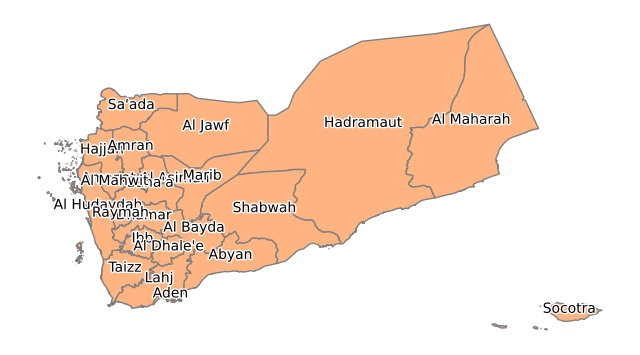

In [17]:
# Plot map.
draw_adminstratas(country = "Yemen", adminstratas_to_highlight = AdminStratas["Yemen"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_rcsi.png", dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The FCG <= 2 dataframe has the values of all 13 administrative regions.

In [18]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

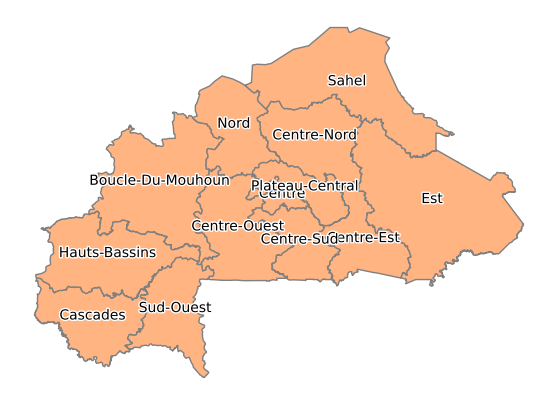

In [19]:
# Plot map.
draw_adminstratas(country = "Burkina Faso", adminstratas_to_highlight = AdminStratas["Burkina Faso"], figsize = (8, 5), 
                  annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_rcsi.png", dpi = 300)

- **Syria (SYR)**: the administrative regions of the Syria country are 14. The rCSI >= 19 dataframe has the values of 13 administrative regions (Idleb administrative region not included).

In [20]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Lattakia', 'Damascus', 'Rural Damascus', "Dar'a", 'Al-Hasakeh',
       'Tartous', 'Hama', 'Aleppo', 'Homs', 'As-Sweida', 'Deir-ez-Zor',
       'Ar-Raqqa', 'Quneitra'], dtype=object)

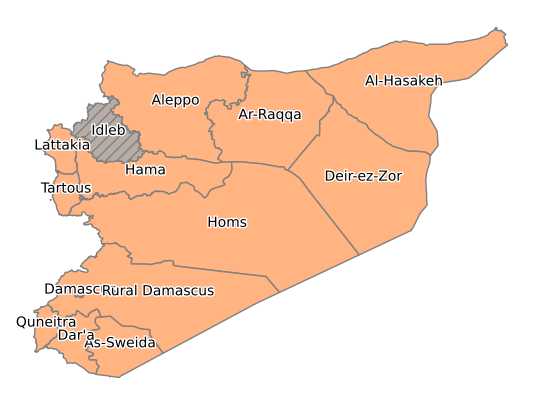

In [21]:
# Plot map.
draw_adminstratas(country = "Syria", adminstratas_to_highlight = AdminStratas["Syria"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Syria/map_rcsi.png", dpi = 300)

- **Cameroon (CMR)**: the administrative regions of Cameroon are 10. The rCSI >= 19 dataframe has the values of all the 10 administrative regions.

In [22]:
print(AdminStratas["Cameroon"].shape)
AdminStratas["Cameroon"]

(10,)


array(['North-West', 'South-West', 'Adamawa', 'Central', 'East',
       'Far-North', 'Littoral', 'North', 'South', 'West'], dtype=object)

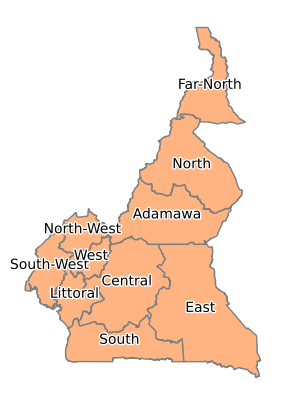

In [23]:
# Plot map.
draw_adminstratas(country = "Cameroon", adminstratas_to_highlight = AdminStratas["Cameroon"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Cameroon/map_rcsi.png", dpi = 300)

- **Mali (MLI)**: Mali is divided into eight regions and one capital district (Bamako). The AdminStrata items of the rCSI >= 19 dataframe cover all 9 regions.

In [24]:
print(AdminStratas["Mali"].shape)
AdminStratas["Mali"]

(9,)


array(['Mopti', 'Segou', 'Tombouctou-Taoudeni', 'Bamako', 'Kayes',
       'Koulikoro', 'Sikasso', 'Gao-Menaka', 'Kidal'], dtype=object)

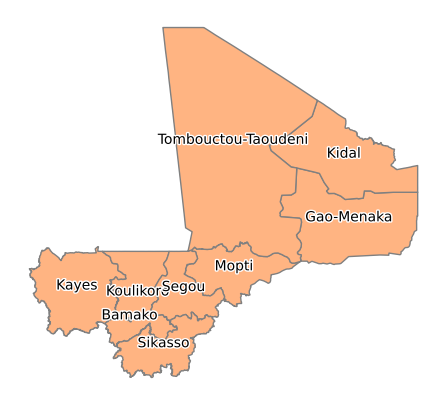

In [25]:
# Plot map.
draw_adminstratas(country = "Mali", adminstratas_to_highlight = AdminStratas["Mali"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Mali/map_rcsi.png", dpi = 300)

- **Nigeria (NGA)**: Nigeria is divided into 36 administrative regions. It also includes The Federal Capital Territory that is is under the direct control of the federal government. The AdminStrata items of the rCSI >= 19 dataframe cover 3 administrative regions: Adamawa, Borno and Yobe.

In [26]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

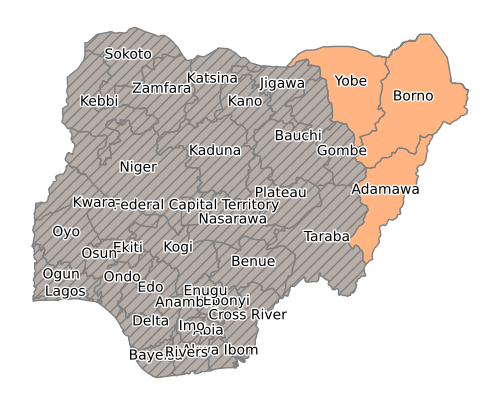

In [27]:
# Plot map.
draw_adminstratas(country = "Nigeria", adminstratas_to_highlight = AdminStratas["Nigeria"], figsize = (8, 5), annotation = True, 
                  annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Nigeria/map_rcsi.png", dpi = 300)

## Data analysis

In [28]:
# Check the min e max values of the rCSI column (% of people with rCSI).
print("min: %f, max: %f" % (df["rCSI"].min(), df["rCSI"].max()))

min: 0.000000, max: 99.974582


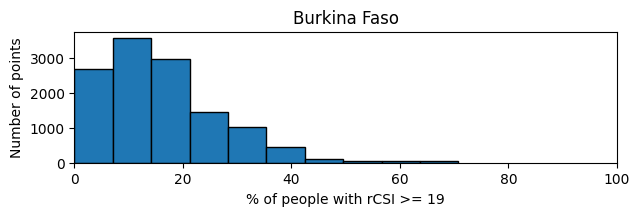

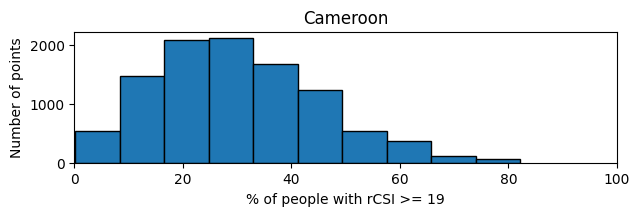

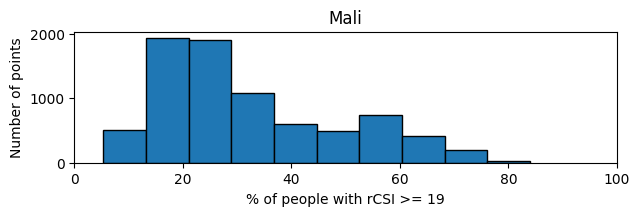

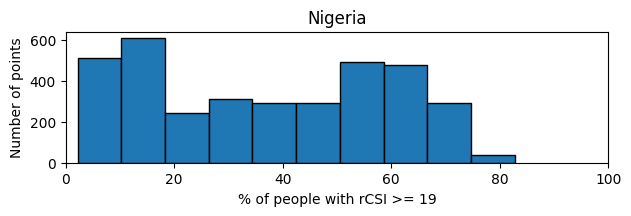

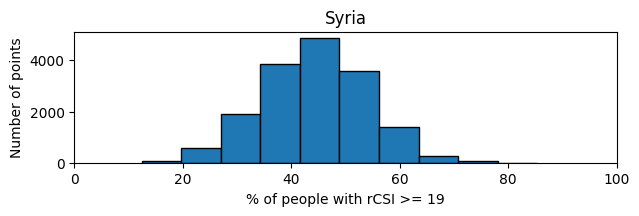

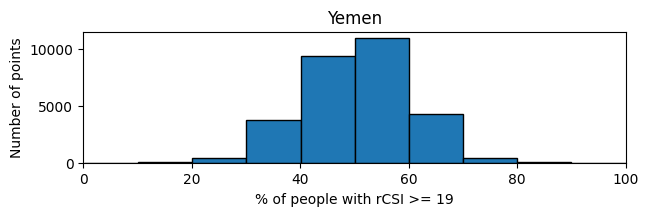

In [29]:
# Create an histogram referred to the values of the metric for each country.
def hist_rcsi(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))
    data = group["rCSI"].dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)
    ax.set_ylabel("Number of points")
    ax.set_xlabel("% of people with rCSI >= 19")
    ax.set_xlim([0, 100])
    plt.show()

df.groupby("Country").apply(hist_rcsi);

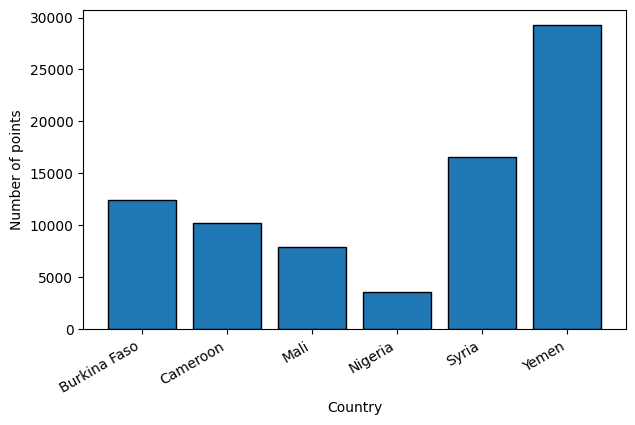

In [30]:
# Create an histogram referred to the number of total points for each country.
n_points = df.groupby("Country")["rCSI"].count()

fig, ax = plt.subplots(figsize = (7, 4.7))
ax.bar(n_points.index, n_points.values, ec = "k")
ax.set_ylabel("Number of points")
ax.set_xlabel("Country")
fig.autofmt_xdate()
plt.show()

## Creation of the time series

We create the time series based on the rCSI and SvyDateRange values.

In [31]:
# Delete the unused columns.
df.drop(["SvyDate", "SvyDate1", "SvyDate2"], axis = 1, inplace = True) 
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
# Create time series.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda x: x.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,rCSI,SvyDateRange
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,19.49950,56.0
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,19.56738,56.0
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,20.40068,56.0
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,20.40558,56.0
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,19.23853,56.0


In [32]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                           \
AdminStrata Boucle-Du-Mouhoun          Cascades            Centre        
Indicator        SvyDateRange rCSI SvyDateRange rCSI SvyDateRange rCSI   
Datetime                                                                 
2018-08-22                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-23                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-24                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-25                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-26                NaN  NaN          NaN  NaN          NaN  NaN   

Country                                          ...        Yemen             \
AdminStrata   Centre-Est       Centre-Nord       ...       Sa'ada              
Indicator   SvyDateRange rCSI SvyDateRange rCSI  ... SvyDateRange       rCSI   
Datetime                                         ...                           
2018-08-22           NaN  NaN          NaN  NaN  ...         31.0  46.435518   
2018-08-23           NaN  NaN          NaN  NaN  ...         31.0  45.261947   
2018-08-24           NaN  NaN          NaN  NaN  ...         31.0  44.520462   
2018-08-25           NaN  NaN          NaN  NaN  ...         31.0  46.345940   
2018-08-26           NaN  NaN          NaN  NaN  ...         31.0  43.294599   

Country                                                                   \
AdminStrata       Sana'a                 Shabwah                 Socotra   
Indicator   SvyDateRange       rCSI SvyDateRange       rCSI SvyDateRange   
Datetime                                                                   
2018-08-22          31.0  52.667849         31.0  34.302200         31.0   
2018-08-23          31.0  50.214606         31.0  36.742499         31.0   
2018-08-24          31.0  50.073157         31.0  35.857748         31.0   
2018-08-25          31.0  48.791655         31.0  34.658434         31.0   
2018-08-26          31.0  48.839640         31.0  35.913080         31.0   

Country                                         
AdminStrata                   Taizz             
Indicator         rCSI SvyDateRange       rCSI  
Datetime                                        
2018-08-22   38.303104         31.0  50.919038  
2018-08-23   39.545071         31.0  50.415852  
2018-08-24   41.867782         31.0  49.391298  
2018-08-25   48.585591         31.0  50.302392  
2018-08-26   48.662394         31.0  50.293046  

[5 rows x 140 columns]

In [33]:
# Plot time series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

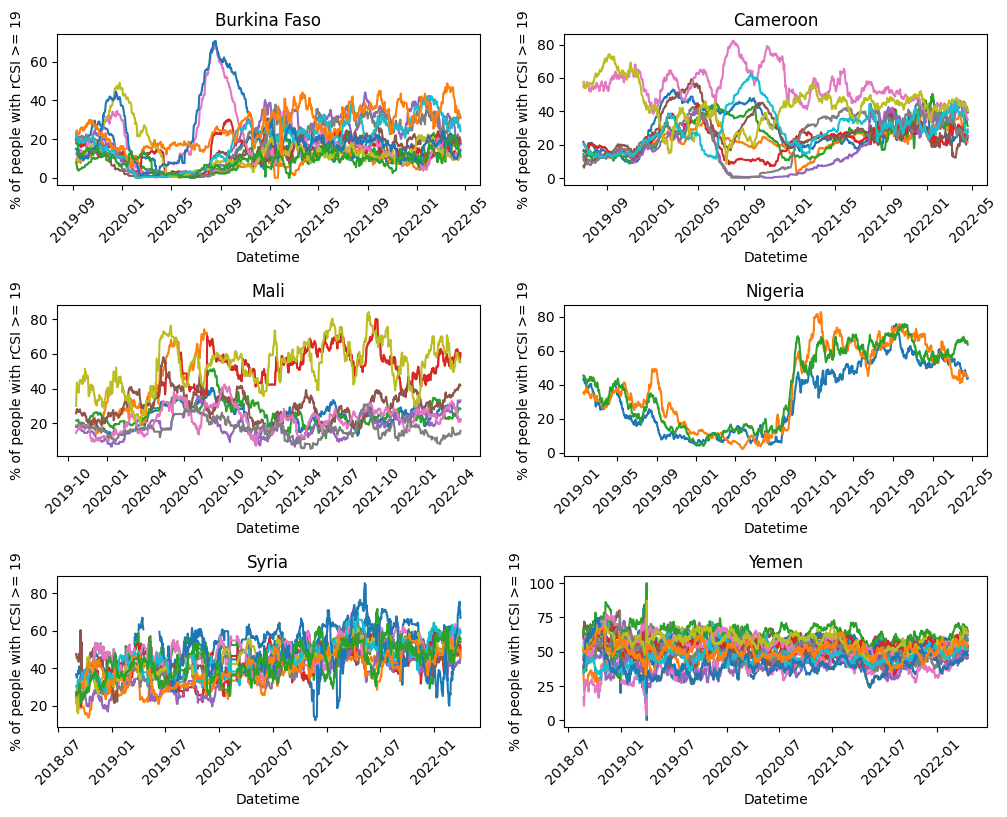

In [34]:
# Plot the original time series of the rCSI indicator for each country.
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 9))
fig.subplots_adjust(hspace = 0.8)
axs = axs.ravel()
for i, country in enumerate(df.columns.get_level_values("Country").unique()):
    axs[i].plot(df[country].xs("rCSI", axis = 1, level = "Indicator", drop_level = False))
    axs[i].set_title(country)
    axs[i].set_xlabel("Datetime")
    axs[i].set_ylabel("% of people with rCSI >= 19")
    axs[i].tick_params(axis = "x", labelrotation = 45)
# Remove extra plot.
#axs[-1].set_axis_off()
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "time_series.png", dpi = 300)

In [35]:
# Now save the time series of each country keeping as indeces for each time series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [36]:
# Save the time series.
df.xs("rCSI", axis = 1, level = "Indicator", drop_level = False).groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_rcsi"));

## Adjustment of the time series: interpolation of NaN values

In [37]:
def check_nan(x): 
    return x.loc[x.first_valid_index():x.last_valid_index()].xs("rCSI", axis = 1, level = 2).isna().sum().sum()

# Check number of nan values.
nans = df.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False).head(10)

Country  AdminStrata     
Syria    Quneitra            178
Mali     Gao-Menaka           56
         Kidal                34
Yemen    Taizz                 3
         Amanat Al Asimah      3
         Abyan                 3
         Aden                  3
         Al Bayda              3
         Al Dhale'e            3
         Al Hudaydah           3
dtype: int64

In [38]:
def interpolation(x): 
    # Let's interpolate the NaN values using a linear interpolation up to a limit of 7 days.
    x = x.loc[x.first_valid_index():x.last_valid_index()]
    x = x.interpolate(method = "linear", limit = 7)
    return x

df_interpolate = df.groupby(axis = 1, level = ["Country", "AdminStrata"], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                           \
AdminStrata Boucle-Du-Mouhoun          Cascades            Centre        
Indicator        SvyDateRange rCSI SvyDateRange rCSI SvyDateRange rCSI   
Datetime                                                                 
2018-08-22                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-23                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-24                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-25                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-26                NaN  NaN          NaN  NaN          NaN  NaN   

Country                                          ...        Yemen             \
AdminStrata   Centre-Est       Centre-Nord       ...       Sa'ada              
Indicator   SvyDateRange rCSI SvyDateRange rCSI  ... SvyDateRange       rCSI   
Datetime                                         ...                           
2018-08-22           NaN  NaN          NaN  NaN  ...         31.0  46.435518   
2018-08-23           NaN  NaN          NaN  NaN  ...         31.0  45.261947   
2018-08-24           NaN  NaN          NaN  NaN  ...         31.0  44.520462   
2018-08-25           NaN  NaN          NaN  NaN  ...         31.0  46.345940   
2018-08-26           NaN  NaN          NaN  NaN  ...         31.0  43.294599   

Country                                                                   \
AdminStrata       Sana'a                 Shabwah                 Socotra   
Indicator   SvyDateRange       rCSI SvyDateRange       rCSI SvyDateRange   
Datetime                                                                   
2018-08-22          31.0  52.667849         31.0  34.302200         31.0   
2018-08-23          31.0  50.214606         31.0  36.742499         31.0   
2018-08-24          31.0  50.073157         31.0  35.857748         31.0   
2018-08-25          31.0  48.791655         31.0  34.658434         31.0   
2018-08-26          31.0  48.839640         31.0  35.913080         31.0   

Country                                         
AdminStrata                   Taizz             
Indicator         rCSI SvyDateRange       rCSI  
Datetime                                        
2018-08-22   38.303104         31.0  50.919038  
2018-08-23   39.545071         31.0  50.415852  
2018-08-24   41.867782         31.0  49.391298  
2018-08-25   48.585591         31.0  50.302392  
2018-08-26   48.662394         31.0  50.293046  

[5 rows x 140 columns]

In [39]:
nans = df_interpolate.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False).head(10)

Country   AdminStrata
Syria     Quneitra       133
Mali      Gao-Menaka      42
          Kidal           27
Yemen     Taizz            0
Cameroon  North-West       0
          South            0
          South-West       0
          West             0
Mali      Bamako           0
          Kayes            0
dtype: int64

In [40]:
# Plot the time series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

In [41]:
# Not consider some provinces.
df_interpolate.drop("Gao-Menaka", axis = 1, level = "AdminStrata", inplace = True)
df_interpolate.drop("Quneitra", axis = 1, level = "AdminStrata", inplace = True)
df_interpolate.drop("Kidal", axis = 1, level = "AdminStrata", inplace = True)

In [42]:
nans = df_interpolate.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False)

Country       AdminStrata        
Yemen         Taizz                  0
Cameroon      Far-North              0
Nigeria       Adamawa                0
Mali          Tombouctou-Taoudeni    0
              Sikasso                0
                                    ..
Syria         Dar'a                  0
              Damascus               0
              As-Sweida              0
              Ar-Raqqa               0
Burkina Faso  Boucle-Du-Mouhoun      0
Length: 67, dtype: int64

In [43]:
# Plot the time series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

## Adjustment of March 2019 month for the Yemen country

We remove the values for the month of March 2019 beacuse it seems to have some anomalies. We then replace the values using a simple linear interpolation.

### Remove and replace month

In [44]:
df_interpolate.loc["2019-3-1":"2019-3-31", "Yemen"] = np.nan

In [45]:
def interpolate_march_Yemen(x):
    if x.name[0] == "Yemen":
        x = x.loc[x.first_valid_index():x.last_valid_index()].interpolate(method = "linear")
        return x
    else:
        return x

In [46]:
df_interpolate = df_interpolate.groupby(level = ["Country", "AdminStrata"], axis = 1, group_keys = False).apply(interpolate_march_Yemen)

In [47]:
# Plot time series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

In [48]:
# Plot time series without survey coverage information.
TsIP(df_interpolate.xs("rCSI", axis = 1, level = "Indicator", drop_level = False)).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Cameroon', 'Mali', 'Niger…

In [49]:
# Save these new time series.
df_interpolate.xs("rCSI", axis = 1, level = "Indicator", drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rcsi-interpolate"));